In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as spm
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.spatial.distance import cdist
from sklearn.cluster import k_means
from scipy.ndimage import gaussian_filter
import cv2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.random.seed(0)


'''
Parts of this code was provided by Johnathan Tay and his refactored R code to Python. His refactorizations can be found at

https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py#L362
    '''
    
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.
    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree + 1  # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

## (1) 2D Bspline basis: 
Denoise the image “space.jpg” using a 2D Bspline basis, and show the resulting image.

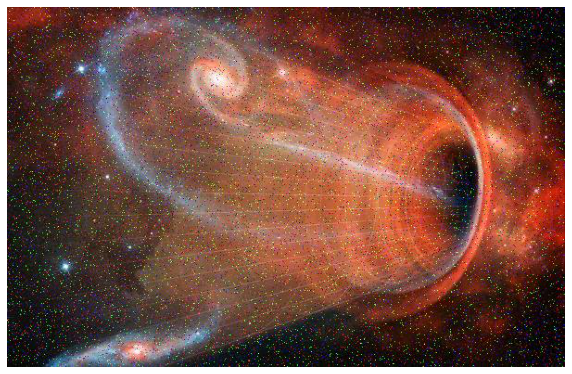

In [2]:
img = plt.imread('space.jpg')
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
def denoise(img, degree, num_knots):
    Bs = []
    Hs = []
    for domain in [img[0, :], img[:, 0]]:
        lo, hi = min(domain), max(domain)
        B = BSplineBasis(np.linspace(domain.min(),domain.max(), len(domain)), knots=np.linspace(
            lo, hi, num_knots), degree=degree)[:, :-2]
        Bs.append(B)
        H = B@np.linalg.pinv(B.T@B)@B.T
        Hs.append(H)

    Yhat = Hs[1]@img@Hs[0]
    return Yhat

In [4]:
def clean(img, degree, num_knots):

    r = denoise(img[:,:,0], degree, num_knots).astype(int)
    g = denoise(img[:,:,1], degree, num_knots).astype(int)
    b = denoise(img[:,:,2], degree, num_knots).astype(int)

    dimg = np.dstack((r,g,b))
    dimg[dimg < 0] = 0
    dimg[dimg > 255] = 255
    return dimg

def plotit(degree):
    numKnots = [10, 50, 100, 150, 200, 250]
    plt.subplots(nrows=2, ncols=3, figsize=(15,8))
    for i in range(6):
        plt.subplot(2,3,i+1)
        denoised = clean(img, degree, numKnots[i])
        plt.imshow(denoised)
        plt.axis('off')
        plt.title('{} Knots'.format(numKnots[i]))
        plt.suptitle('Degree {} B-spline'.format(degree),size=25)  
    plt.show()
    print()
    print()

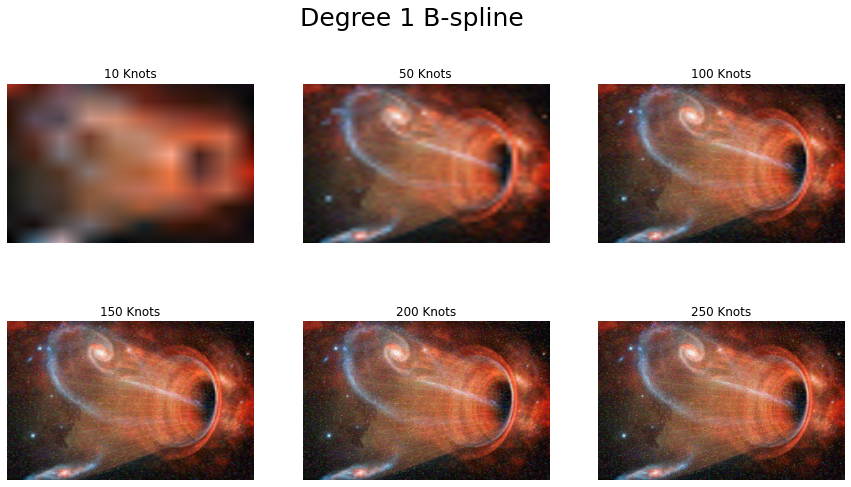

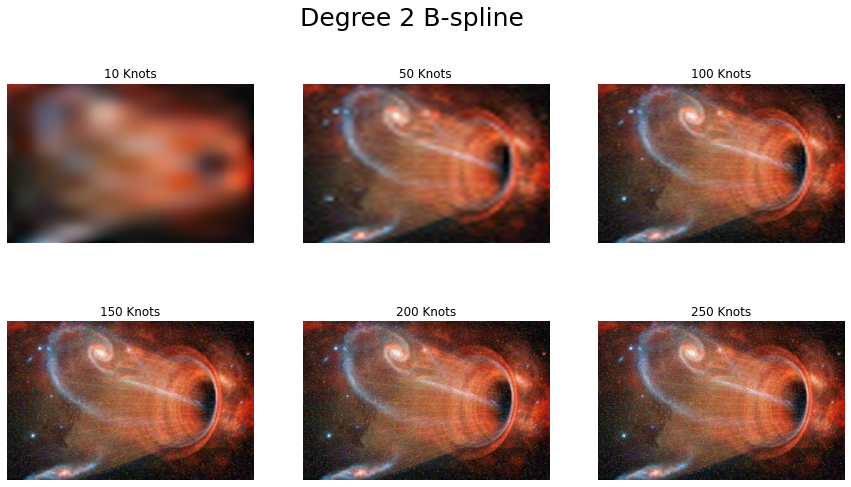

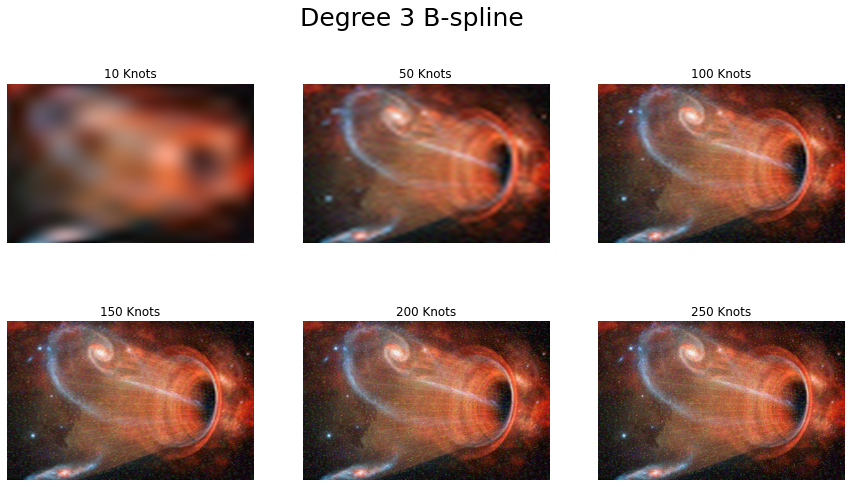

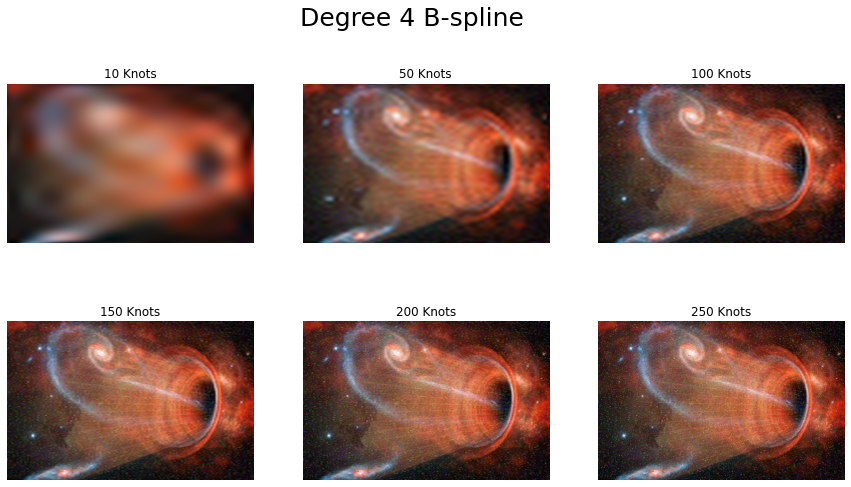

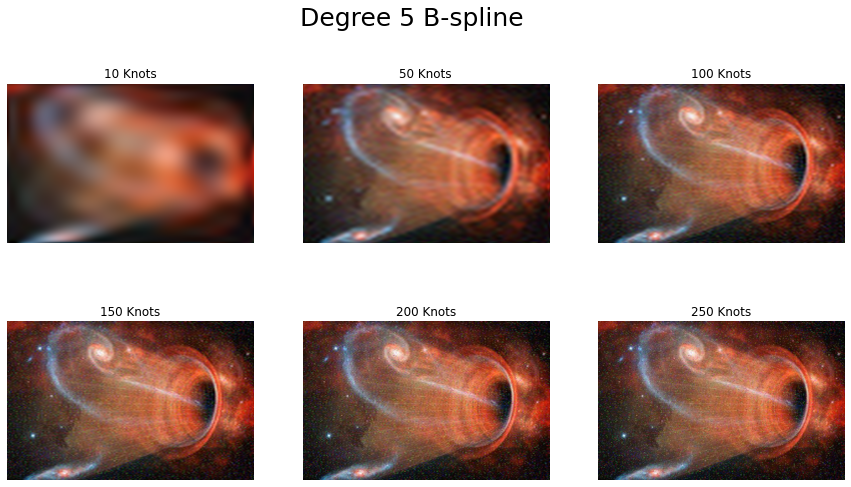

In [5]:
for i in range(1,6):
    plotit(i)

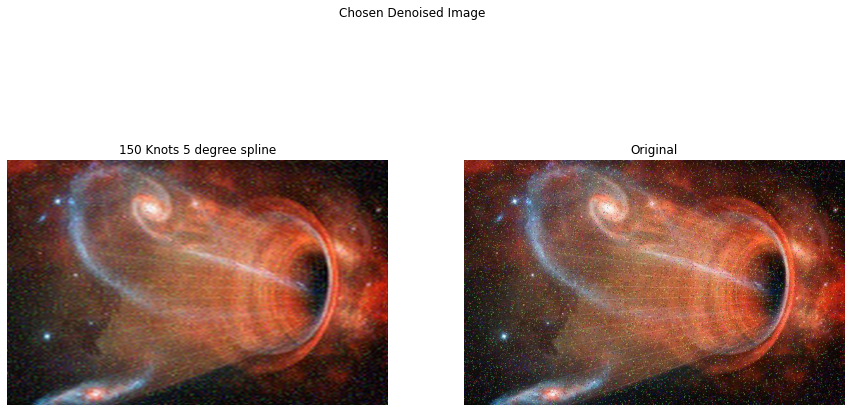

In [6]:
plt.subplots(1,2,figsize=(15,8))
plt.subplot(121)
plt.imshow(clean(img, 5, 150))
plt.axis('off')
plt.title('150 Knots 5 degree spline')
plt.subplot(122)
plt.imshow(img)
plt.axis('off')
plt.title('Original')
plt.suptitle('Chosen Denoised Image')
plt.show()

## (2) Threshold-Averaging Method: 
Denoise the image using “space.jpg” the following steps, and show the resulting image.

### (a) Denoise the image using the following blurring mask: 
\begin{equation}
\frac{1}{9}
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}
\end{equation}

In [7]:
def denoise2(img):
    def mask(chan):
        mask = np.array([[ 1,  1,  1], [1,  1, 1],[1, 1, 1]], dtype=np.float32) * (1.0 / 9.0)
        dimg = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, mask), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        return dimg
    
    c1 = mask(img[:,:,0])
    c2 = mask(img[:,:,1])
    c3 = mask(img[:,:,2])
    
    return np.dstack((c1,c2,c3))

### Given the threshold $\tau$=0.003, g(i,j), the final intensity of the pixel located at (i,j) of the resulting image can be obtained as follows
\begin{equation}
g(i,j)=
\begin{cases}
a(i,j), \text{if |a(i,j) - f(i,j) | > }\tau\\
f(i,j), \text{else}
\end{cases}
\end{equation}

In [8]:
def threshold(img, dimg):
    orig_shape = dimg.shape

    #flatten original image and normalize
    img = img.ravel().reshape(-1,1).astype(float) / 255
    
    #flatten a(i,j) image and normalize 
    dimg = dimg.ravel().reshape(-1,1).astype(float) / 255
    #normalize between 0 and 1

    #calculate diff
    diff = np.abs((img - dimg)).ravel()
    
    #find indices that are lower than the threshold of 0.003
    thresh_idx = np.argwhere(diff <= 0.003).ravel()
    
    #set the pixels in denoised image back to oringal pixel values for those at thresh_idx
    dimg[thresh_idx] = img[thresh_idx]
    
    return dimg.reshape(orig_shape)

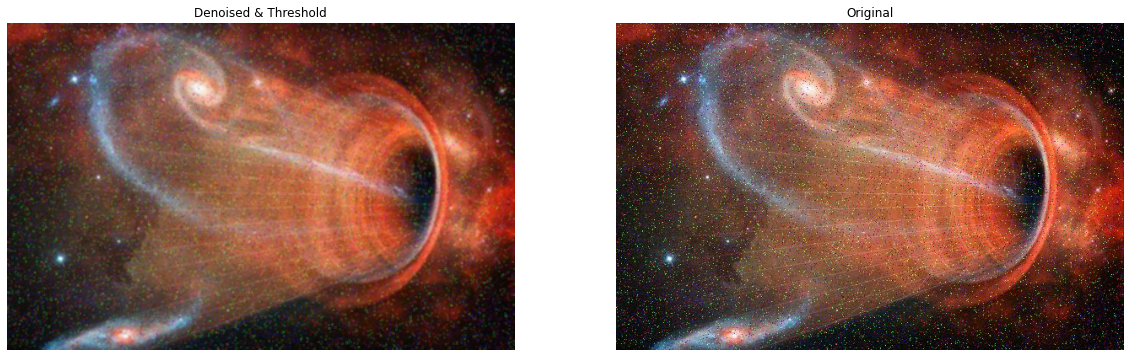

In [9]:
dimg = threshold(img, denoise2(img))

plt.subplots(nrows=1,ncols=2,figsize=(20,10))
plt.subplot(121)
plt.imshow(dimg)
plt.axis('off')
plt.title('Denoised & Threshold')
plt.subplot(122)
plt.imshow(img)
plt.axis('off')
plt.title('Original')
plt.show()

## (3) Pyramid Blending:
The primary goal of this part is to seamlessly blend an object or texture from a source image (the “Image_source.jpg”) into a background image (the denoised “space.jpg”). The simplest method would be to just copy and paste the pixels from one image directly into the other. Unfortunately, this will create very noticeable seams, even if the backgrounds are well-matched. How can we get rid of these seams without doing too much perceptual damage to the source region? The insight is that people often care much more about the gradient of an image than the overall intensity. Laplacian pyramid blending is a technique for blending, that decomposes the source image and background image using a Laplacian pyramid and then would combine and collapsed them to get the final image.We want to blend the “Image_source.jpg” in to the denoised image of “space.jpg” you got from previous parts (Pick one on your choice from part 1 or 2). To make your job easier, we provided the mask for you, file “Mask_source”. This image is aligning the source image and background image and you need it for part of blending algorithm. To do the Pyramid Blending, follow the below steps:

### (a) Build the Laplacian pyramids of “Image_source.jpg” and denoised “space.jpg”.
To build the one layer of pyramid, you have to pass both images to a Gaussian filter, then subtract the original images from their corresponding smoothed images and you will have one layer of Laplacian Pyramid.

### (b) To get the next level of the pyramid, you should down sample the Gaussain filter passed images from the previous part.

In [10]:
#utilizing threshold averaging above
smoothed = dimg.copy()
source = plt.imread('Image_source.jpg').astype(float) / 255
mask = plt.imread('Mask_source.jpg').astype(float) / 255

#### Gaussian Pyramid

In [11]:
def gauss_pyramid(image, pyramid_size=6):
    #store each level of the pyramid
    gs = []
    #make a copy to avoid alteration from pass by value
    img = image.copy()
    #append base of the pyramid
    gs.append(img)
    
    for i in range(pyramid_size):
        #downsampling gauss filter
        img = cv2.pyrDown(img)
        gs.append(img)
    return gs

#### Laplacian Pyramid

In [12]:
def lap_pyramid(levels):
    #store each level f the pyramid
    laps = []
    #can't do anything with the very tip of the pyrmid, append the next layer down
    laps.append(levels[-2].copy())
    
    for i in range(5,0,-1):
        #get next layer's shape
        H,W = levels[i-1].shape[:2]
        #gaussian upscale to the next layers shape
        gauss_up = cv2.pyrUp(levels[i].copy(), dstsize=(W,H))
        #subtract gaussian to create laplacian
        lap = cv2.subtract(levels[i-1].copy(), gauss_up)
        #append layer
        laps.append(lap)
        
    return laps

#### Break up images into rgb components

In [13]:
#break up into rgb components
rsmooth = smoothed[:,:,0].copy()
gsmooth = smoothed[:,:,1].copy()
bsmooth = smoothed[:,:,2].copy()

rsource = source[:,:,0].copy()
gsource = source[:,:,1].copy()
bsource = source[:,:,2].copy()

#### Gauss pyramid of smoothed (denoised) and source image

In [14]:
rgsmooth = gauss_pyramid(rsmooth, 6)
ggsmooth = gauss_pyramid(gsmooth, 6)
bgsmooth = gauss_pyramid(bsmooth, 6)

rgsource = gauss_pyramid(rsource, 6)
ggsource = gauss_pyramid(gsource, 6)
bgsource = gauss_pyramid(bsource, 6)

#### lap pyramid of soothed and source image

In [15]:
rlsmooth = lap_pyramid(rgsmooth)
glsmooth = lap_pyramid(ggsmooth)
blsmooth = lap_pyramid(bgsmooth)

rlsource = lap_pyramid(rgsource)
glsource = lap_pyramid(ggsource)
blsource = lap_pyramid(bgsource)

### (c) To do the Pyramid blending, you also have to build the Gaussian pyramid of “Mask_source” image. The process is the same as part (b), except that you should not subtract from original image (Just keep the Gaussian smoothed one)

In [16]:
#create gauss pyramid of the mask and reverse the order
gauss_mask = list(reversed(gauss_pyramid(mask, 6)[:-1]))

#### (d) Form a combined pyramid from Laplacian pyramids of denoised space and image source, using nodes of the Gaussian pyramid of mask as weights:

Combined pyramid = (mask pyramid)*( Laplacian pyramids of image source) +
                                    (1- mask pyramid)*( Laplacian pyramids of denoised space)
Then collapse the combined pyramid to get the final blended image.

In [17]:
def blending(LA,LB,M):
    LS = []
    for la,lb,gm in zip(LA,LB,M):

        b = (gm) * (lb) + (1-gm) * (la)

        LS.append(b)

    return LS

In [18]:
rblend = blending(rlsmooth, rlsource, gauss_mask)
gblend = blending(glsmooth, glsource, gauss_mask)
bblend = blending(blsmooth, blsource, gauss_mask)

In [19]:
def reconstruct(blend):
    #starting off with the top of the pyramid
    ls = blend[0]
    for i in range(1,len(blend)):
        #get shape of the next layer
        H,W = blend[i].shape[:2]
        #upsample to next layer size
        ls = cv2.pyrUp(ls, dstsize=(W,H))
        #collapse layer into next layer
        ls = cv2.add(ls, blend[i])
    return ls

In [20]:
#recontruct r,g,b components
r = reconstruct(rblend)
g = reconstruct(gblend)
b = reconstruct(bblend)

# RESULTS

## Gaussian Pyramid of the denoised image

In [21]:
components = []
for R,G,B in zip(rgsmooth,ggsmooth,bgsmooth):
    i = np.dstack((R,G,B))
    components.append(i)

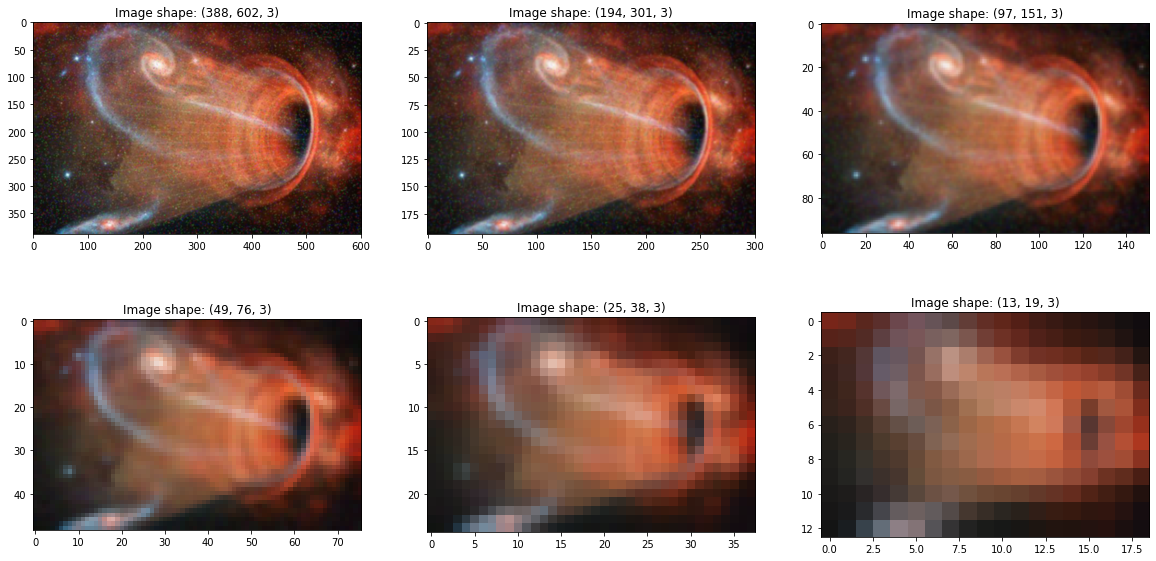

In [22]:
plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for pos, i in enumerate(components[:-1]):
    plt.subplot(2,3,pos+1)
    plt.imshow(i)
    plt.title('Image shape: {}'.format(i.shape))

## Gaussian Pyramid of the source image

In [23]:
components = []
for R,G,B in zip(rgsource,ggsource,bgsource):
    i = np.dstack((R,G,B))
    components.append(i)

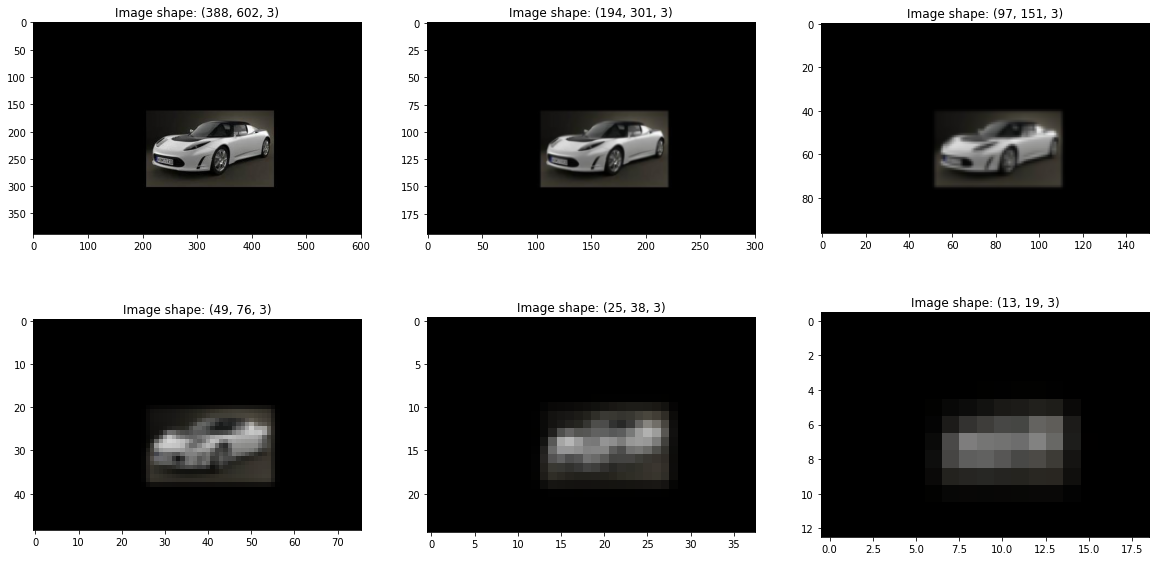

In [24]:
plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for pos, i in enumerate(components[:-1]):
    plt.subplot(2,3,pos+1)
    plt.imshow(i)
    plt.title('Image shape: {}'.format(i.shape))

## Blended Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


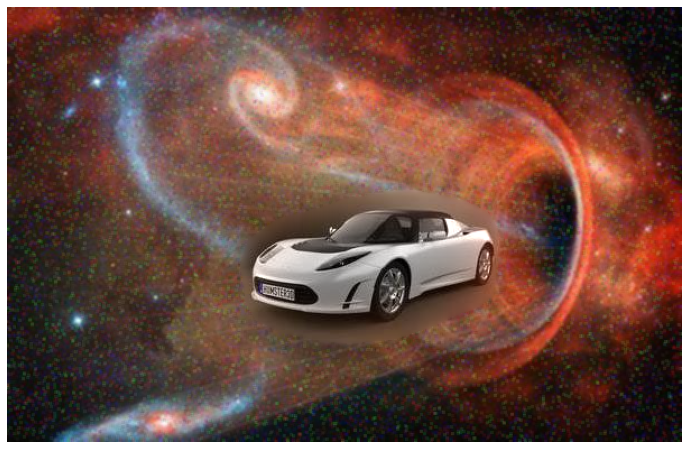

In [25]:
plt.figure(figsize=(15,8))
plt.imshow(np.dstack((r,g,b)))
plt.axis('off')
plt.show()